In [ ]:
!pip install antspyx
!pip install statsmodels
!pip install barbar


     |████████████████████████████████| 300.3 MB 39 kB/s 
     |████████████████████████████████| 64 kB 4.1 MB/s 


In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ants
import nibabel as nib

from barbar import Bar
from operator import add
import sys
import shutil

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim import Adadelta,Adam


from google.colab import drive

!git clone https://github.com/sergivalverde/MAIA_seminar.git

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'MAIA_seminar'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 23), reused 56 (delta 13), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


####Hyperparameters

In [ ]:

numEpochs     = 100
blockStepSize = 16   
batchSize     = 128
numLabels     = 5

####Modified U-NET

In [ ]:
##Modified U-net from the basic one provided in Dr. Sergi Valverde's Workshop

class Modified3DUNet(nn.Module):
	def __init__(self, in_channels, n_classes, base_n_filter = 8):
		super(Modified3DUNet, self).__init__()
		self.in_channels = in_channels
		self.n_classes = n_classes
		self.base_n_filter = base_n_filter

		self.lrelu = nn.LeakyReLU()
		self.dropout3d = nn.Dropout3d(p=0.6)
		self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
		self.softmax = nn.Softmax(dim=1)

		# Level 1 context pathway
		self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
		self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
		self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

		# Level 2 context pathway
		self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
		self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

		# Level 3 context pathway
		self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
		self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

		# Level 4 context pathway
		self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
		self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 5 context pathway, level 0 localization pathway
		self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
		self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
		self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

		self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
		self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

		# Level 1 localization pathway
		self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
		self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

		# Level 2 localization pathway
		self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
		self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

		# Level 3 localization pathway
		self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
		self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
		self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

		# Level 4 localization pathway
		self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
		self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

		self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter*8, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)
		self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter*4, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)




	def conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def norm_lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def lrelu_conv(self, feat_in, feat_out):
		return nn.Sequential(
			nn.LeakyReLU(),
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

	def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
		return nn.Sequential(
			nn.InstanceNorm3d(feat_in),
			nn.LeakyReLU(),
			nn.Upsample(scale_factor=2, mode='nearest'),
			# should be feat_in*2 or feat_in
			nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
			nn.InstanceNorm3d(feat_out),
			nn.LeakyReLU())

	def forward(self, x):
		#  Level 1 context pathway
		out = self.conv3d_c1_1(x)
		residual_1 = out
		out = self.lrelu(out)
		out = self.conv3d_c1_2(out)
		out = self.dropout3d(out)
		out = self.lrelu_conv_c1(out)
		# Element Wise Summation
		out += residual_1
		context_1 = self.lrelu(out)
		out = self.inorm3d_c1(out)
		out = self.lrelu(out)

		# Level 2 context pathway
		out = self.conv3d_c2(out)
		residual_2 = out
		out = self.norm_lrelu_conv_c2(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c2(out)
		out += residual_2
		out = self.inorm3d_c2(out)
		out = self.lrelu(out)
		context_2 = out

		# Level 3 context pathway
		out = self.conv3d_c3(out)
		residual_3 = out
		out = self.norm_lrelu_conv_c3(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c3(out)
		out += residual_3
		out = self.inorm3d_c3(out)
		out = self.lrelu(out)
		context_3 = out

		# Level 4 context pathway
		out = self.conv3d_c4(out)
		residual_4 = out
		out = self.norm_lrelu_conv_c4(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c4(out)
		out += residual_4
		out = self.inorm3d_c4(out)
		out = self.lrelu(out)
		context_4 = out

		# Level 5
		out = self.conv3d_c5(out)
		residual_5 = out
		out = self.norm_lrelu_conv_c5(out)
		out = self.dropout3d(out)
		out = self.norm_lrelu_conv_c5(out)
		out += residual_5
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

		out = self.conv3d_l0(out)
		out = self.inorm3d_l0(out)
		out = self.lrelu(out)

		# Level 1 localization pathway
		out = torch.cat([out, context_4], dim=1)
		out = self.conv_norm_lrelu_l1(out)
		out = self.conv3d_l1(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

		# Level 2 localization pathway
		out = torch.cat([out, context_3], dim=1)
		out = self.conv_norm_lrelu_l2(out)
		ds2 = out
		out = self.conv3d_l2(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

		# Level 3 localization pathway
		out = torch.cat([out, context_2], dim=1)
		out = self.conv_norm_lrelu_l3(out)
		ds3 = out
		out = self.conv3d_l3(out)
		out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

		# Level 4 localization pathway
		out = torch.cat([out, context_1], dim=1)
		out = self.conv_norm_lrelu_l4(out)
		out_pred = self.conv3d_l4(out)

		ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
		ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
		ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
		ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
		ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

		out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale


		out = F.softmax(out, dim=1) 
		return out

#### Functions

In [ ]:
def saveCheckpoint(state, filename):
    torch.save(state, filename)

def loadCheckpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

####Based On Sergi Valverde's workshop


class MRI_DataPatchLoader(Dataset):
    """
    Data loader experiments

    """

    def __init__(self,
                 input_data,
                 labels,
                 rois,
                 patch_size,
                 sampling_step,
                 random_pad=(0, 0, 0),
                 sampling_type='mask',
                 normalize=False,
                 min_sampling_th=0,
                 num_pos_samples=5000,
                 resample_epoch=False,
                 transform=None):
        """
        Arguments:
        - input_data: dict containing a list of inputs for each training scan
        - labels: dict containing a list of labels for each training scan
        - roi: dict containing a list of roi masks for each training scan
        - patch_size: patch size
        - sampling_step: sampling_step
        - sampling type: 'all: all voxels in input_mask,
                         'roi: all voxels in roi_mask,
                         'balanced: same number of positive and negative voxels
        - normalize: Normalize data (0 mean / 1 std)
        - min_sampling_th: Minimum value to extract samples (0 default)
        - num_pos_samples used when hybrid sampling
        - transform
        """

        self.patch_size = patch_size
        self.sampling_step = sampling_step
        self.random_pad = random_pad
        self.sampling_type = sampling_type
        self.patch_half = tuple([idx // 2 for idx in self.patch_size])
        self.normalize = normalize
        self.min_th = min_sampling_th
        self.resample_epoch = resample_epoch
        self.transform = transform
        self.num_pos_samples = num_pos_samples

        # preprocess scans

        # load MRI scans in memory
        self.input_scans, self.label_scans, self.roi_scans = self.load_scans(input_data,
                                                                             labels,
                                                                             rois,
                                                                             apply_padding=True)
        
        
        self.num_modalities = len(self.input_scans[0])
        self.input_train_dim = (self.num_modalities, ) + self.patch_size
        self.input_label_dim = (1, ) + self.patch_size

        # normalize scans if set update
        if normalize:
            self.input_scans = [[normalize_data(self.input_scans[i][m])
                                for m in range(self.num_modalities)]
                                for i in range(len(self.input_scans))]

        # Build the patch indexes based on the image index and the voxel
        # coordenates

        self.patch_indexes = self.generate_patch_indexes(self.roi_scans)

        print('> DATA: Training sample size:', len(self.patch_indexes))

    def __len__(self):
        """
        Get the legnth of the training set
        """
        return len(self.patch_indexes)

    def __getitem__(self, idx):
        """
        Get the next item. Resampling the entire dataset is considered if
        self.resample_epoch is set to True.
        """

        if idx == 0 and self.resample_epoch:
            self.patch_indexes = self.generate_patch_indexes(self.roi_scans)

        im_ = self.patch_indexes[idx][0]
        center = self.patch_indexes[idx][1]

        slice_ = [slice(c_idx-p_idx, c_idx+s_idx-p_idx)
                  for (c_idx, p_idx, s_idx) in zip(center,
                                                   self.patch_half,
                                                   self.patch_size)]

        # get current patches for both training data and labels
        input_train = np.stack([self.input_scans[im_][m][tuple(slice_)]
                                for m in range(self.num_modalities)], axis=0)
        input_label = np.expand_dims(
            self.label_scans[im_][0][tuple(slice_)], axis=0)

        # check dimensions and put zeros if necessary
        if input_train.shape != self.input_train_dim:
            print('error in patch', input_train.shape, self.input_train_dim)
            input_train = np.zeros(self.input_train_dim).astype('float32')
        if input_label.shape != self.input_label_dim:
            print('error in label')
            input_label = np.zeros(self.input_label_dim).astype('float32')

        if self.transform:
            input_train, input_label = self.transform([input_train,
                                                       input_label])

        return input_train, input_label

    def apply_padding(self, input_data, mode='constant', value=0):
        """
        Apply padding to edges in order to avoid overflow

        """

        padding = tuple((idx, size-idx)
                        for idx, size in zip(self.patch_half, self.patch_size))
        
   
        padded_image = np.pad(input_data,
                              padding,
                              mode=mode,
                              constant_values=value)

        return padded_image

    def load_scans(self,
                   input_data,
                   label_data,
                   roi_data,
                   apply_padding=True,
                   apply_canonical=False):
        """
        Applying padding to input scans. Loading simultaneously input data and
        labels in order to discard missing data in both sets.
        """

        input_scans = []
        label_scans = []
        roi_scans = []

        

        for s in input_data.keys():
            """
            for i in range(len(input_data[s])):
              dummy = nib.load(input_data[s][i]).get_fdata()
              if(dummy.ndim ==4):
                plt.imshow(dummy[128,:,:,0])
                plt.show()
             
              elif(dummy.ndim ==3):
                plt.imshow(dummy[128,:,:])
                plt.show()
              print(dummy.shape)
            """
            try:
                if apply_padding:

                    for i in range(len(input_data[s])):
                      input_load = nib.load(input_data[s][i]).get_fdata().astype('float32')
                      if(input_load.ndim ==4):
                        input_ = [self.apply_padding(np.squeeze(input_load,axis=3))]
                      elif(input_load.ndim ==3):
                        input_ = [self.apply_padding(input_load)]
                    
                    for i in range(len(label_data[s])):

                      label_load = nib.load(label_data[s][i]).get_fdata().astype('float32')
                      if(label_load.ndim ==4):
                        label_ = [self.apply_padding(np.squeeze(label_load,axis=3))]
                      elif(label_load.ndim ==3):
                        label_ = [self.apply_padding(label_load)]

                      
                      
                    
                    roi_ = [self.apply_padding(nib.load(roi_data[s][i]).get_fdata().astype('float32'))for i in range(len(roi_data[s]))]
                    input_scans.append(input_)
                    label_scans.append(label_)
                    roi_scans.append(roi_)
                    print('> DATA: Loaded scan', s,
                          'roi size:',  np.sum(roi_[0] > 0),
                          'label_size: ', np.sum(label_[0] > 0))
                else:

                    for i in range(len(input_data[s])):
                      input_load = nib.load(input_data[s][i]).get_fdata().astype('float32')
                      if(input_load.ndim ==4):
                        input_ = [(np.squeeze(nib.load(input_data[s][i]).get_fdata().astype('float32'),axis=3))]
                      elif(input_load.ndim ==3):
                        input_ = [(nib.load(input_data[s][i]).get_fdata().astype('float32'))]
                    
                    for i in range(len(label_data[s])):
                      label_load = nib.load(label_data[s][i]).get_fdata().astype('float32')
                      if(label_load.ndim ==4):
                        label_ = [(np.squeeze(nib.load(label_data[s][i]).get_fdata().astype('float32'),axis=3))]
                      elif(label_load.ndim ==3):
                        label_ = [(nib.load(label_data[s][i]).get_fdata().astype('float32'))]



                    
                    roi_ = [(nib.load(roi_data[s][i]).get_fdata().astype('float32')) for i in range(len(roi_data[s]))]
                    input_scans.append(input_)
                    label_scans.append(label_)
                    roi_scans.append(roi_)
                    print('> DATA: Loaded scan', s, 'roi size:',
                          np.sum(roi_[0] > 0))
            except:
                print('> DATA: Error loading scan', s, '... Discarding')
                

        return input_scans, label_scans, roi_scans

    def generate_patch_indexes(self, roi_scans):
        """
        Generate indexes to extract. Consider the sampling step and
        a initial random padding
        """
        training_indexes = []
        # patch_half = tuple([idx // 2 for idx in self.patch_size])
        for s, l, r, i in zip(self.input_scans,
                              self.label_scans,
                              roi_scans,
                              range(len(self.input_scans))):

            # sample candidates
            candidate_voxels = self.get_candidate_voxels(s[0], l[0], r[0])
            voxel_coords = get_voxel_coordenates(s[0],
                                                 candidate_voxels,
                                                 step_size=self.sampling_step,
                                                 random_pad=self.random_pad)
            training_indexes += [(i, tuple(v)) for v in voxel_coords]

        return training_indexes

    def get_candidate_voxels(self, input_mask, label_mask, roi_mask):
        """
        Sample input mask using different techniques:
        - all: extracts all voxels > 0 from the input_mask
        - mask: extracts all roi voxels
        - balanced: same number of positive and negative voxels from
                    the input_mask as defined by the roi mask
        - balanced+roi: same number of positive and negative voxels from
                    the roi and label mask

        - hybrid sampling:
          1. Set a number of positive samples == self.pos_samples
          2. Displace randomly its x, y, z position < self.patch_half
          3. Get the same number of negative samples from the roi mask
        """

        if self.sampling_type == 'image':
            sampled_mask = input_mask > 0

        if self.sampling_type == 'all':
            sampled_mask = input_mask > 0

        if self.sampling_type == 'mask':
            sampled_mask = roi_mask > 0

        if self.sampling_type == 'balanced':
            sampled_mask = label_mask > 0
            num_positive = np.sum(label_mask > 0)
            brain_voxels = np.stack(np.where(input_mask > self.min_th), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:num_positive]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        if self.sampling_type == 'balanced+roi':
            sampled_mask = label_mask > 0
            num_positive = np.sum(label_mask > 0)
            roi_mask[label_mask == 1] = 0
            brain_voxels = np.stack(np.where(roi_mask > 0), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:num_positive]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        if self.sampling_type == 'hybrid':
            x, y, z = np.where(label_mask > 0)
            number_of_samples = len(x)

            # sample voxels randomly until size equals self.num_samples
            if number_of_samples < self.num_pos_samples:
                expand_interval = int(self.num_pos_samples / number_of_samples) + 1
                x = np.repeat(x, expand_interval)
                y = np.repeat(y, expand_interval)
                z = np.repeat(z, expand_interval)

            index_perm = np.random.permutation(range(len(x)))
            x = x[index_perm][:self.num_pos_samples]
            y = y[index_perm][:self.num_pos_samples]
            z = z[index_perm][:self.num_pos_samples]

            # randomize the voxel center
            min_int_x = - self.patch_half[0] +1
            max_int_x = self.patch_half[0] -1
            min_int_y = - self.patch_half[1] +1
            max_int_y = self.patch_half[1] -1
            min_int_z = - self.patch_half[2] +1
            max_int_z = self.patch_half[2] -1
            x += np.random.randint(low=min_int_x,
                                   high=max_int_x,
                                    size=x.shape)
            y += np.random.randint(low=min_int_y,
                                   high=max_int_y,
                                   size=y.shape)
            z += np.random.randint(low=min_int_z,
                                   high=max_int_z,
                                   size=z.shape)

            # check boundaries
            x = np.maximum(self.patch_half[0], x)
            x = np.minimum(label_mask.shape[0] - self.patch_half[0], x)
            y = np.maximum(self.patch_half[1], y)
            y = np.minimum(label_mask.shape[1] - self.patch_half[1], y)
            z = np.maximum(self.patch_half[2], z)
            z = np.minimum(label_mask.shape[2] - self.patch_half[2], z)

            # assign the same number of positive and negative voxels
            sampled_mask = np.zeros_like(label_mask)

            # positive samples
            for x_v, y_v, z_v in zip(x, y, z):
                sampled_mask[x, y, z] = 1

            # negative samples
            brain_voxels = np.stack(np.where(roi_mask > 0), axis=1)
            for voxel in np.random.permutation(brain_voxels)[:self.num_pos_samples]:
                sampled_mask[voxel[0], voxel[1], voxel[2]] = 1

        return sampled_mask


def extract_patches(input_image,
                    roi=None,
                    voxel_coords=None,
                    patch_size=(15, 15, 15),
                    step_size=(1, 1, 1)):
    """
    Extract patches of size patch_size from an input image given as input

    inputs:
    - input_image:  3D np.array
    - roi: region of interest to extract samples. input_image > 0 if not set
    - voxel_coords: Already computed voxel coordenades
    - patch_size: output patch size
    - step_size: sampling overlap in x, y and z

    output:
    - list of sampled patches: 4D array [n, patch_size] eg: (100, 15, 15 ,15)
    - list of voxel_coordenates
    """

    # check roi
    if roi is None:
        roi = input_image > 0

    # get voxel coordenates taking into account step sampling if those are
    # not passed as input
    if voxel_coords is None:
        voxel_coords = get_voxel_coordenates(input_image,
                                             roi,
                                             step_size=step_size)

    # extract patches based on the sampled voxel coordenates
    out_patches = get_patches(input_image, voxel_coords, patch_size)

    return out_patches, voxel_coords


def get_voxel_coordenates(input_data,
                          roi,
                          random_pad=(0, 0, 0),
                          step_size=(1, 1, 1)):
    """
    Get voxel coordenates based on a sampling step size or input mask.
    For each selected voxel, return its (x,y,z) coordinate.

    inputs:
    - input_data (useful for extracting non-zero voxels)
    - roi: region of interest to extract samples. input_data > 0 if not set
    - step_size: sampling overlap in x, y and z
    - random_pad: initial random padding applied to indexes

    output:
    - list of voxel coordenates
    """

    # compute initial padding
    r_pad = np.random.randint(random_pad[0]+1) if random_pad[0] > 0 else 0
    c_pad = np.random.randint(random_pad[1]+1) if random_pad[1] > 0 else 0
    s_pad = np.random.randint(random_pad[2]+1) if random_pad[2] > 0 else 0

    # precompute the sampling points based on the input
    sampled_data = np.zeros_like(input_data)
    for r in range(r_pad, input_data.shape[0], step_size[0]):
        for c in range(c_pad, input_data.shape[1], step_size[1]):
            for s in range(s_pad, input_data.shape[2], step_size[2]):
                sampled_data[r, c, s] = 1

    # apply sampled points to roi and extract sample coordenates
    # [x, y, z] = np.where(input_data * roi * sampled_data)
    [x, y, z] = np.where(roi * sampled_data)

    # return as a list of tuples
    return [(x_, y_, z_) for x_, y_, z_ in zip(x, y, z)]


def get_patches(input_data, centers, patch_size=(15, 15, 15)):
    """
    Get image patches of arbitrary size based on a set of voxel coordenates

    inputs:
    - input_data: a tridimensional np.array matrix
    - centers:  centre voxel coordenate for each patch
    - patch_size: patch size (x,y,z)

    outputs:
    - patches: np.array containing each of the patches
    """
    # If the size has even numbers, the patch will be centered. If not,
    # it will try to create an square almost centered. By doing this we allow
    # pooling when using encoders/unets.
    patches = []
    list_of_tuples = all([isinstance(center, tuple) for center in centers])
    sizes_match = [len(center) == len(patch_size) for center in centers]

    if list_of_tuples and sizes_match:
        # apply padding to the input image and re-compute the voxel coordenates
        # according to the new dimension
        padded_image = apply_padding(input_data, patch_size)
        patch_half = tuple([idx // 2 for idx in patch_size])
        new_centers = [map(add, center, patch_half) for center in centers]
        # compute patch locations
        slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
                   for (c_idx, p_idx, s_idx) in zip(center,
                                                    patch_half,
                                                    patch_size)]
                  for center in new_centers]

        # extact patches
        patches = [padded_image[tuple(idx)] for idx in slices]

    return np.array(patches)


def reconstruct_image(input_data, centers, output_size):
    """
    Reconstruct image based on several ovelapping patch samples

    inputs:
    - input_data: a np.array list with patches
    - centers: center voxel coordenates for each patch
    - output_size: output image size (x,y,z)

    outputs:
    - reconstructed image
    """

    # apply a padding around edges before writing the results
    # recompute the voxel dimensions
    patch_size = input_data[0, :].shape
    out_image = apply_padding(np.zeros(output_size), patch_size)
    patch_half = tuple([idx // 2 for idx in patch_size])
    new_centers = [map(add, center, patch_half) for center in centers]
    # compute patch locations
    slices = [[slice(c_idx-p_idx, c_idx+s_idx-p_idx)
               for (c_idx, p_idx, s_idx) in zip(center,
                                                patch_half,
                                                patch_size)]
              for center in new_centers]

    # for each patch, sum it to the output patch and
    # then update the frequency matrix

    freq_count = np.zeros_like(out_image)

    for patch, slide in zip(input_data, slices):
        out_image[tuple(slide)] += patch
        freq_count[tuple(slide)] += np.ones(patch_size)

    # invert the padding applied for patch writing
    out_image = invert_padding(out_image, patch_size)
    freq_count = invert_padding(freq_count, patch_size)

    # the reconstructed image is the mean of all the patches
    out_image /= freq_count
    out_image[np.isnan(out_image)] = 0

    return out_image


def apply_padding(input_data, patch_size, mode='constant', value=0):
    """
    Apply padding to edges in order to avoid overflow

    """

    patch_half = tuple([idx // 2 for idx in patch_size])
    padding = tuple((idx, size-idx)
                    for idx, size in zip(patch_half, patch_size))

    padded_image = np.pad(input_data,
                          padding,
                          mode=mode,
                          constant_values=value)

    return padded_image


def invert_padding(padded_image, patch_size):
    """
    Invert paadding on edges to recover the original shape

    inputs:
    - padded_image defined by apply_padding function
    - patch_size (x,y,z)

    """

    patch_half = tuple([idx // 2 for idx in patch_size])
    padding = tuple((idx, size-idx)
                    for idx, size in zip(patch_half, patch_size))

    return padded_image[padding[0][0]:-padding[0][1],
                        padding[1][0]:-padding[1][1],
                        padding[2][0]:-padding[2][1]]

def normalize_data(im,
                   norm_type='standard',
                   brainmask=None,
                   datatype=np.float32):
    """
    Zero mean normalization

    inputs:
    - im: input data
    - nomr_type: 'zero_one', 'standard'

    outputs:
    - normalized image
    """
    mask = np.copy(im > 0 if brainmask is None else brainmask)

    im = im.astype(dtype=datatype) - im[np.nonzero(im)].mean()
    im = im / im[np.nonzero(im)].std()

    # do not apply normalization to non-brain parts
    # im[mask==0] = 0
    return im


def dice_coef_multi(true_out, pred_out, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    
    class_num = numLabels
    for i in range(class_num):
        y_pred_f = torch.flatten(pred_out[:,i,:,:,:])
        y_true_f = torch.flatten(true_out[:,0,:,:,:]==i)
        intersection = torch.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return (1 - total_loss)


def mask_image(im):
    return (im > 0).astype('float32')


def get_inference_patches(scan_path, input_data, roi, patch_shape, step, normalize=True):
    """
    Get patches for inference

    inputs:
    - scan path: path/to/the/subject to infer
    - input_data: list containing the input modality names
    - roi: ROI mask name
    - patch_shape: patch size
    - step: sampling step
    - normalize = zero mean normalization

    outputs:
    - test patches (samples, channels, x, y, z)
    - ref voxels coordenates  extracted

    """


    # get candidate voxels
    mask_image = nib.load(os.path.join(scan_path, roi))

    

    ref_mask, ref_voxels = get_candidate_voxels(mask_image.get_fdata(),
                                                step,
                                                sel_method='all')

    # input images stacked as channels
    test_patches = get_data_channels(scan_path,
                                     input_data,
                                     ref_voxels,
                                     patch_shape,
                                     step,
                                     normalize=normalize)


    return test_patches, ref_voxels


def get_data_channels(image_path,
                      scan_names,
                      ref_voxels,
                      patch_shape,
                      step,
                      normalize=False):
    """
    Get data for each of the channels
    """
    out_patches = []
    for s in scan_names:
        current_scan = os.path.join(image_path, s)
        patches, _ = get_input_patches(current_scan,
                                       ref_voxels,
                                       patch_shape,
                                       step,
                                       normalize=normalize)
        out_patches.append(patches)

    return np.concatenate(out_patches, axis=1)


def get_input_patches(scan_path,
                      ref_voxels,
                      patch_shape,
                      step,
                      normalize=False,
                      expand_dims=True):
    """
    get current patches for a given scan
    """
    # current_scan = nib.as_closest_canonical(nib.load(scan_path)).get_fdata()
    current_scan = np.squeeze(nib.load(scan_path).get_fdata(),axis=3)

    if normalize:
        current_scan = normalize_data(current_scan)

    patches, ref_voxels = extract_patches(current_scan,
                                          voxel_coords=ref_voxels,
                                          patch_size=patch_shape,
                                          step_size=step)

    if expand_dims:
        patches = np.expand_dims(patches, axis=1)

    return patches, ref_voxels


def get_candidate_voxels(input_mask,  step_size, sel_method='all'):
    """
    Extract candidate patches.
    """

    if sel_method == 'all':
        candidate_voxels = input_mask > 0

        voxel_coords = get_voxel_coordenates(input_mask,
                                             candidate_voxels,
                                             step_size=step_size)
    return candidate_voxels, voxel_coords

###DataInput

In [ ]:
options = {}

options['training_path'] = '/content/drive/My Drive/MISAProject/Training_Set'
options['validation_path'] = '/content/drive/My Drive/MISAProject//Validation_Set'
options['test_path'] = '/content/drive/My Drive/MISAProject/Test_Set'

options['train_split']  = 0
options['input_data'] = ['T1.nii.gz']

options['gt_data'] = '5labels_seg.nii.gz'

####Applying the Mask to get the ROI

In [ ]:
options['roi'] = 'brainmask.nii.gz'


for scan_id in os.listdir(options['training_path']):
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        'T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       options['roi']))
                     
for scan_id in os.listdir(options['validation_path']):
    scan = ants.image_read(os.path.join(options['validation_path'], 
                                        scan_id, 
                                        'T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['validation_path'], 
                                       scan_id, 
                                       options['roi']))

for scan_id in os.listdir(options['test_path']):
    scan = ants.image_read(os.path.join(options['test_path'], 
                                        scan_id, 
                                        'T1.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['test_path'], 
                                       scan_id, 
                                       options['roi']))   

####Splitting Training data 

In [ ]:
training_scans = os.listdir(options['training_path'])
training_scans.sort()
        

In [ ]:
if options['train_split'] != 0:
    # t_d = int(len(training_scans) * (1 - options['train_split']))
    # training_data = training_scans[:t_d]
    # validation_data = training_scans[t_d:]
    validation_data = [training_scans[3],training_scans[5],training_scans[-1]]
    validation_data

    training_data = []
    for x in training_scans:
        if x != validation_data[0] and x != validation_data[1] and x != validation_data[2]:
            training_data.append(x)
else:
    training_data = training_scans
    validation_data = os.listdir(options['validation_path'])
    
  


In [ ]:
training_data , validation_data

(['IBSR_01',
  'IBSR_03',
  'IBSR_04',
  'IBSR_05',
  'IBSR_06',
  'IBSR_07',
  'IBSR_08',
  'IBSR_09',
  'IBSR_16',
  'IBSR_18'],
 ['IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_11', 'IBSR_17'])

In [ ]:

training_data

['IBSR_01',
 'IBSR_03',
 'IBSR_04',
 'IBSR_05',
 'IBSR_06',
 'IBSR_07',
 'IBSR_08',
 'IBSR_09',
 'IBSR_16',
 'IBSR_18']

In [ ]:
validation_data

['IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_11', 'IBSR_17']

In [ ]:

input_train_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}

input_val_data = {scan: [os.path.join(options['validation_path'], scan, d)
                         for d in options['input_data']]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['validation_path'], scan, options['gt_data'])] 
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['validation_path'], scan, options['roi'])] 
                      for scan in validation_data}

In [ ]:
input_train_data

{'IBSR_01': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_01/T1.nii.gz'],
 'IBSR_03': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_03/T1.nii.gz'],
 'IBSR_04': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_04/T1.nii.gz'],
 'IBSR_05': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_05/T1.nii.gz'],
 'IBSR_06': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_06/T1.nii.gz'],
 'IBSR_07': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_07/T1.nii.gz'],
 'IBSR_08': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_08/T1.nii.gz'],
 'IBSR_09': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_09/T1.nii.gz'],
 'IBSR_16': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_16/T1.nii.gz'],
 'IBSR_18': ['/content/drive/My Drive/MISAProject/Training_Set/IBSR_18/T1.nii.gz']}

In [ ]:
input_val_data

{'IBSR_11': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_11/T1.nii.gz'],
 'IBSR_12': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_12/T1.nii.gz'],
 'IBSR_13': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_13/T1.nii.gz'],
 'IBSR_14': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_14/T1.nii.gz'],
 'IBSR_17': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_17/T1.nii.gz']}

In [ ]:
input_val_data

{'IBSR_11': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_11/T1.nii.gz'],
 'IBSR_12': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_12/T1.nii.gz'],
 'IBSR_13': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_13/T1.nii.gz'],
 'IBSR_14': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_14/T1.nii.gz'],
 'IBSR_17': ['/content/drive/My Drive/MISAProject//Validation_Set/IBSR_17/T1.nii.gz']}

In [ ]:

options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (blockStepSize, blockStepSize, blockStepSize)
options['normalize'] = True 
options['batch_size'] = batchSize

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

Training data: 
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1157459
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  959179
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1080321
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  1045609
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  1082340
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  870635
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  872704
> DATA: Loaded scan IBSR_09 roi size: 1002429 label_size:  1007318
> DATA: Loaded scan IBSR_16 roi size: 1460808 label_size:  1466493
> DATA: Loaded scan IBSR_18 roi size: 1668281 label_size:  1680639
> DATA: Training sample size: 2745
Validation data: 
> DATA: Loaded scan IBSR_12 roi size: 954168 label_size:  959645
> DATA: Loaded scan IBSR_13 roi size: 1058473 label_size:  1080677
> DATA: Loaded scan IBSR_14 roi size: 1140358 label_size:  1146500
> DATA: Loaded scan IBSR_11 roi size: 958119 label_size:  962112
> D

###Train

In [ ]:
CUDA_LAUNCH_BLOCKING=1

lesion_model = Modified3DUNet(in_channels =1, n_classes=numLabels)
options['gpu_use'] = True
options['num_epochs'] = numEpochs

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
optimizer = Adam(lesion_model.parameters(), lr=0.003)

In [ ]:

checkpointAddress = "/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_AllData.pth.tar"

loadModel = False

In [ ]:

if loadModel:
  loadCheckpoint(torch.load(checkpointAddress),lesion_model,optimizer = Adam(lesion_model.parameters(), lr=0.003))

In [ ]:
bestAccuracy = 0

# send the model to the device
lesion_model = lesion_model.to(device)


training_metrics=np.zeros((options['num_epochs'],4))

# training loop
training = True
epoch = 1
try:
    while training:
        print('Epoch: {}/{}'.format(epoch,options['num_epochs']))

    
        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for b_train, batch in enumerate(Bar(training_dataloader)):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss.
                
                loss = dice_coef_multi(y,pred)


                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
              
                optimizer.step()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                train_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b_val, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                    if(lossFunction == 1):
                      loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)), y.squeeze(dim=1).long())
                    elif(lossFunction == 2):
                      loss = dice_coef_multi(y,pred)


                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    batch_accuracy = pred.eq(y.view_as(pred).long())
                    val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
        
        # compute mean metrics
        train_loss /= (b_train + 1)
        train_accuracy /= (b_train + 1)
        val_loss /= (b_val + 1)
        val_accuracy /= (b_val + 1)

        print('Epoch {:d}: train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
            epoch, 
            train_loss, 
            train_accuracy,
            val_loss,
            val_accuracy))
        
        if bestAccuracy<val_accuracy:
          bestAccuracy=val_accuracy
          print("We have a better one. Saving Model")
          checkpoint = {'state_dict' : lesion_model.state_dict(), 'optimizer' : optimizer.state_dict() }
          saveCheckpoint(checkpoint,filename=checkpointAddress)

        training_metrics[(epoch - 1),[0,1,2,3]]=[train_loss, train_accuracy, val_loss, val_accuracy]
        # update epochs
        epoch += 1
        
        # save weights
        # torch.save(lesion_model.state_dict(), 
        #           os.path.join('models3', 'model' + str(epoch) + '.pt'))
        
        
        

        if epoch >= options['num_epochs']+1:
            training = False
except KeyboardInterrupt:
    pass

Epoch: 1/100
2745/2745: [==============================>.] - ETA 1.0s
Epoch 1: train_loss 0.5146 train_acc 0.7313 val_loss 0.3761 val_acc 0.8219
We have a better one. Saving Model
Epoch: 2/100
2745/2745: [==============================>.] - ETA 0.7s
Epoch 2: train_loss 0.3204 train_acc 0.8323 val_loss 0.3018 val_acc 0.8471
We have a better one. Saving Model
Epoch: 3/100
2745/2745: [==============================>.] - ETA 0.7s
Epoch 3: train_loss 0.2407 train_acc 0.8591 val_loss 0.2184 val_acc 0.8761
We have a better one. Saving Model
Epoch: 4/100
2745/2745: [==============================>.] - ETA 0.7s
Epoch 4: train_loss 0.2046 train_acc 0.8766 val_loss 0.1948 val_acc 0.8904
We have a better one. Saving Model
Epoch: 5/100
2745/2745: [==============================>.] - ETA 0.7s
Epoch 5: train_loss 0.1775 train_acc 0.8895 val_loss 0.1785 val_acc 0.8965
We have a better one. Saving Model
Epoch: 6/100
2745/2745: [==============================>.] - ETA 0.7s
Epoch 6: train_loss 0.1629 tra

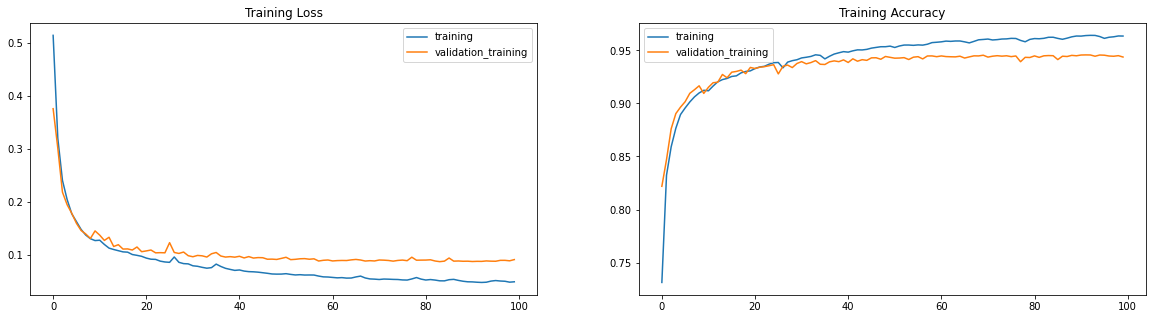

In [ ]:
fig=plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(training_metrics[:,[0,2]])
plt.legend(["training","validation_training"])
plt.title('Training Loss') 
fig.add_subplot(1, 2, 2)
plt.plot(training_metrics[:,[1,3]])
plt.legend(["training","validation_training"])
plt.title('Training Accuracy') 
plt.show()

###Evaluate

In [ ]:
checkpointAddress
Modified3DUNET_5Labels_AllData.pth.tar

'/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_Epoch100_alltrainingdata.pt'

In [ ]:
checkpointAddress = "/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_AllData.pth.tar"

In [ ]:
# #checkpointAddress = "/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_Epoch"+str(83)+".pt"
# checkpointAddress = "/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_Epoch95.pt"  
checkpointAddress = "/content/drive/My Drive/MISAProject/Modified3DUNET_5Labels_Epoch100_lastThreeVal.pt"  
loadCheckpoint(torch.load(checkpointAddress),lesion_model,optimizer = Adam(lesion_model.parameters(), lr=0.003))

=> Loading checkpoint


In [ ]:
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
lesion_model.to(device=device)

Modified3DUNet(
  (lrelu): LeakyReLU(negative_slope=0.01)
  (dropout3d): Dropout3d(p=0.6, inplace=False)
  (upsacle): Upsample(scale_factor=2.0, mode=nearest)
  (softmax): Softmax(dim=1)
  (conv3d_c1_1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (conv3d_c1_2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (lrelu_conv_c1): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (inorm3d_c1): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3d_c2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
  (norm_lrelu_conv_c2): Sequential(
    (0): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padd

/content/drive/My Drive/MISAProject//Validation_Set/IBSR_12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:504: RuntimeWarning:

invalid value encountered in true_divide



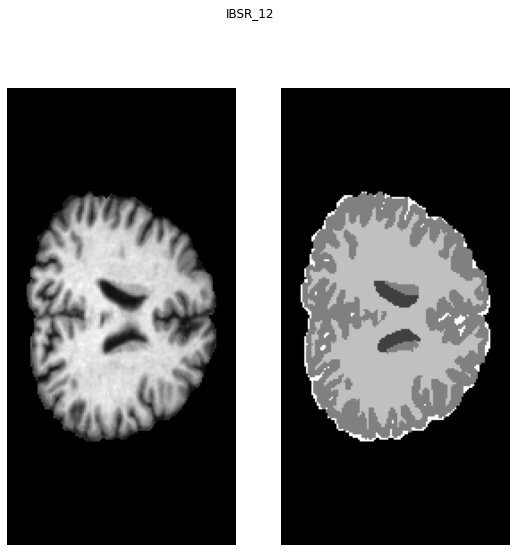

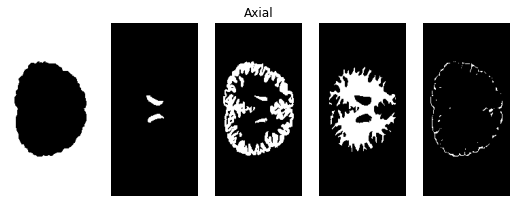

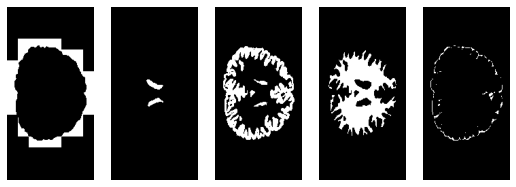

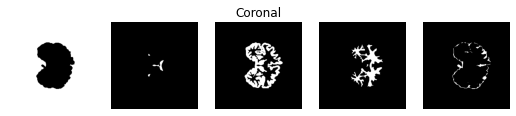

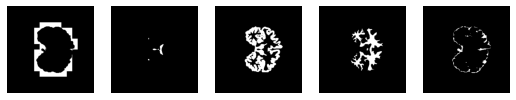

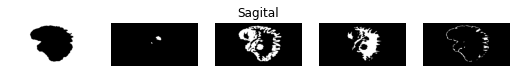

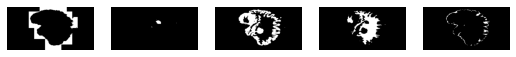

/content/drive/My Drive/MISAProject//Validation_Set/IBSR_13


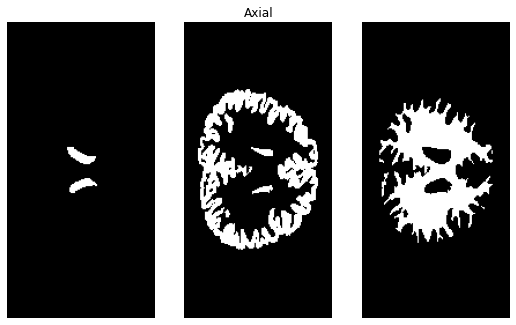

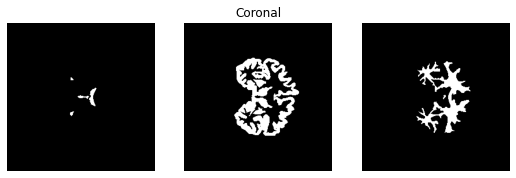

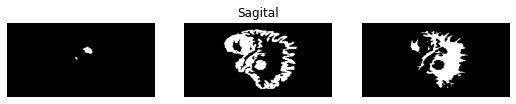

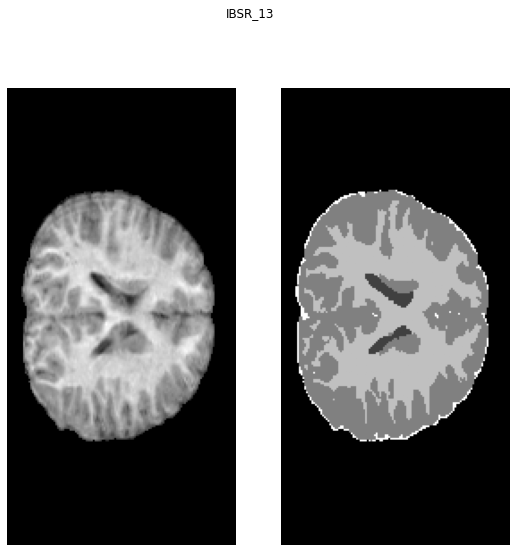

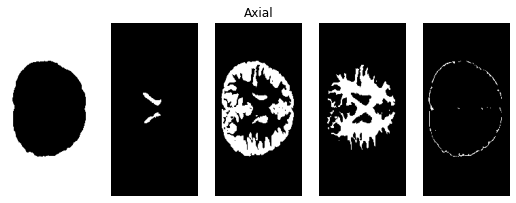

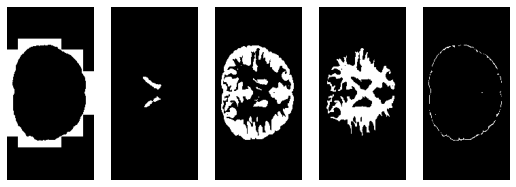

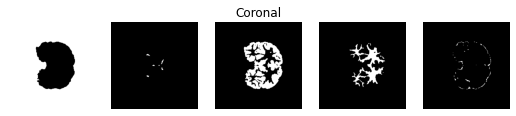

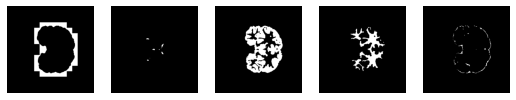

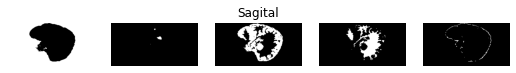

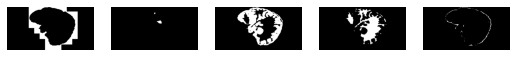

/content/drive/My Drive/MISAProject//Validation_Set/IBSR_14


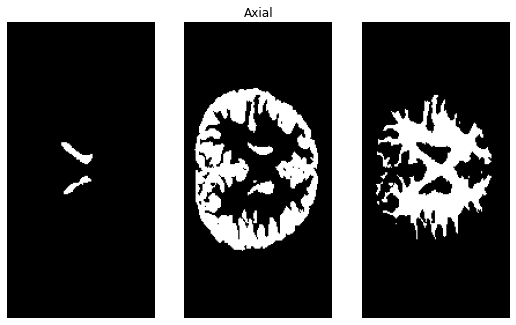

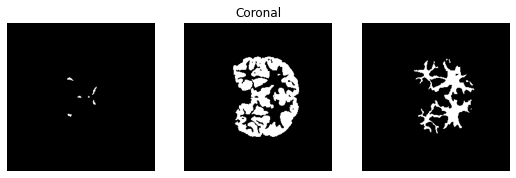

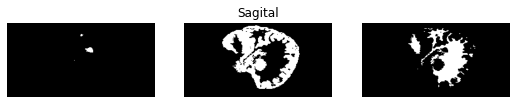

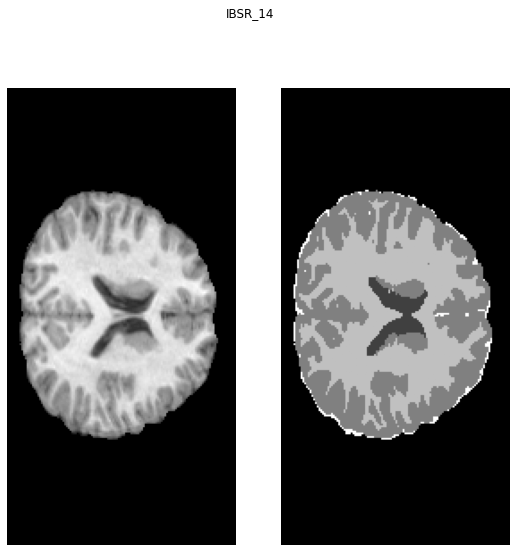

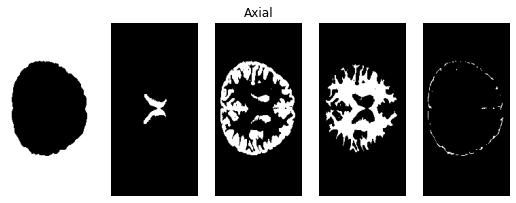

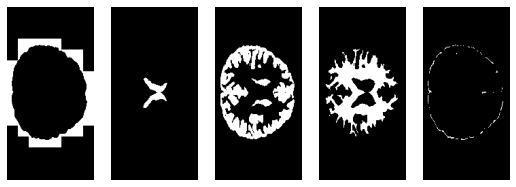

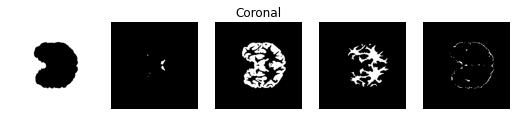

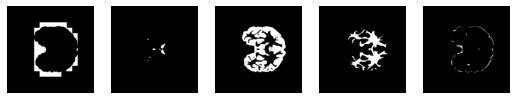

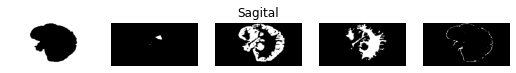

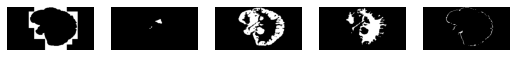

/content/drive/My Drive/MISAProject//Validation_Set/IBSR_11


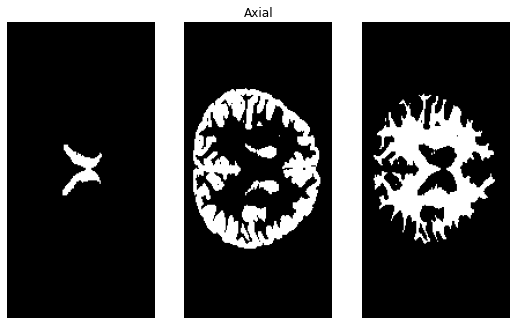

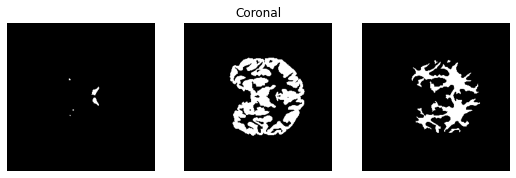

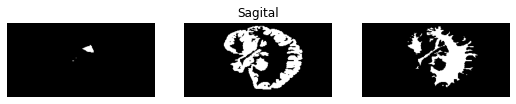

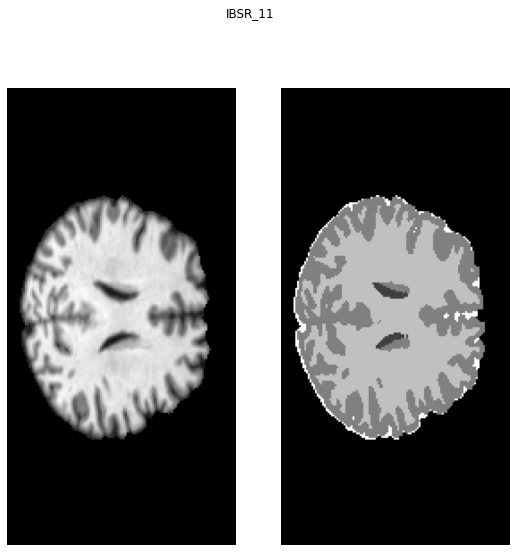

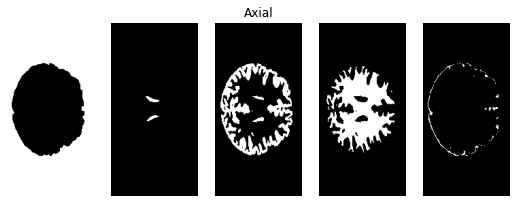

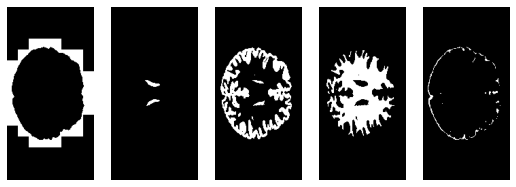

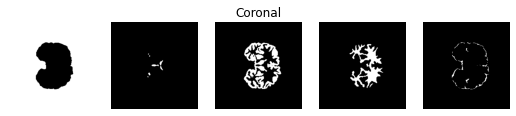

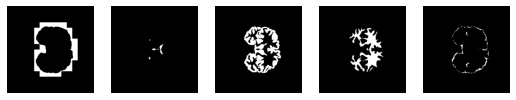

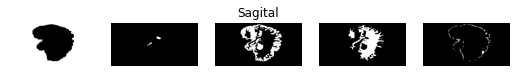

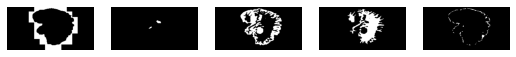

/content/drive/My Drive/MISAProject//Validation_Set/IBSR_17


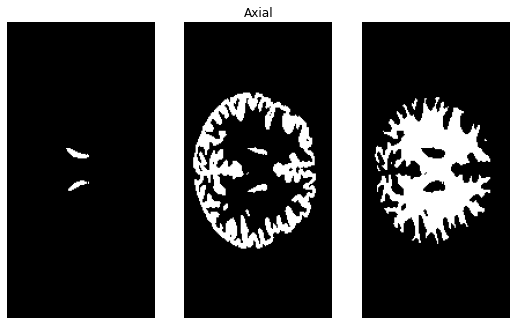

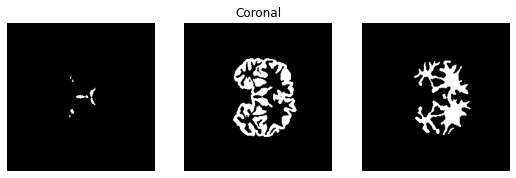

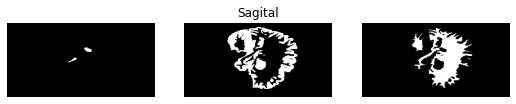

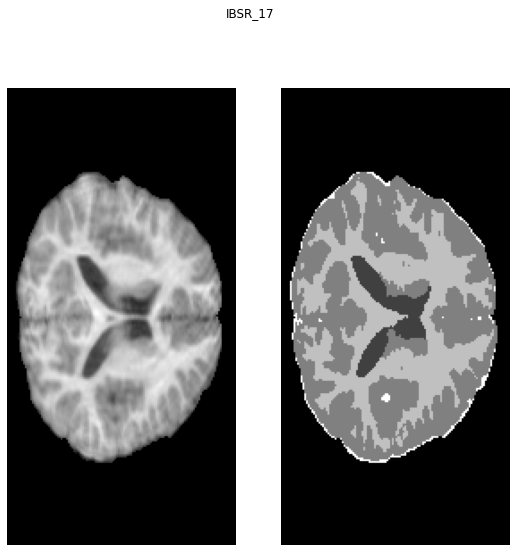

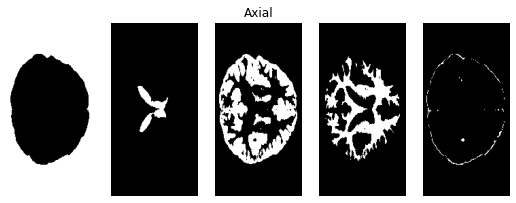

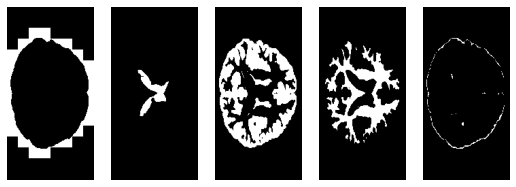

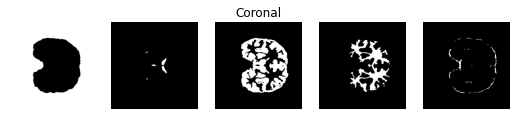

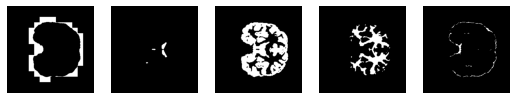

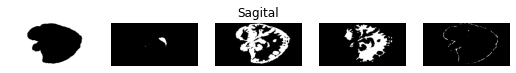

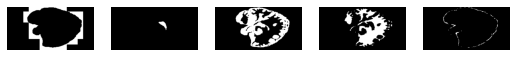

,count,mean,std,min,25%,50%,75%,max
DSC CSF:,5.0,0.910254,0.005615,0.905648,0.906206,0.908735,0.911188,0.919492
DSC GM:,5.0,0.947281,0.006176,0.936981,0.946058,0.950694,0.950858,0.951813
DSC WM:,5.0,0.942091,0.012021,0.930449,0.934234,0.940063,0.944343,0.961366
TPF CSF:,5.0,0.627564,0.150920,0.375000,0.615385,0.666667,0.730769,0.750000
TPF GM:,5.0,0.525000,0.130437,0.333333,0.500000,0.500000,0.625000,0.666667
TPF WM:,5.0,0.605410,0.182759,0.307692,0.608696,0.631579,0.675159,0.803922
PPV CSF:,5.0,0.790492,0.164996,0.600000,0.688995,0.745098,0.918367,1.000000
PPV GM:,5.0,0.364988,0.063790,0.267504,0.343849,0.372093,0.415343,0.426150
PPV WM:,5.0,0.474420,0.031354,0.438819,0.442857,0.488790,0.494976,0.506661


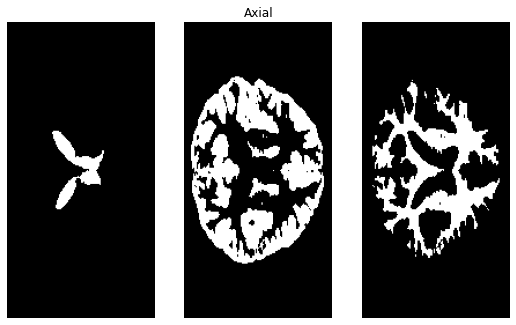

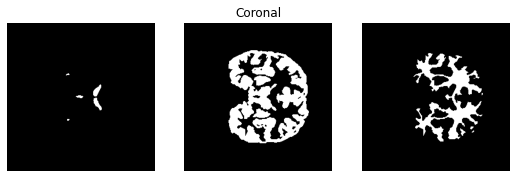

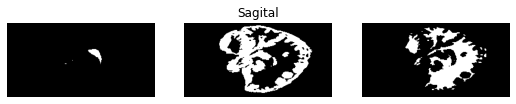

In [ ]:

from MAIA_seminar.metrics import DSC_seg, TPF_det, PPV_det

slice_no = 150
slice_no_coronal = 65

enable_plot = True

# obtain a list of test scans
test_scans = os.listdir(options['validation_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 9))

for i, scan_name in enumerate(test_scans):
    
    scan_path = os.path.join(options['validation_path'], scan_name)
    volumeName = scan_path[len(scan_path)-7:len(scan_path)]
    print(scan_path)

    #from MAIA_seminar.utils import get_inference_patches, reconstruct_image
    scan = ants.image_read(os.path.join(scan_path, 'T1.nii.gz'))
    if(numLabels == 4):
      scan_labels = ants.image_read(os.path.join(scan_path, 'seg.nii.gz'))
    elif(numLabels == 5):
      scan_labels = ants.image_read(os.path.join(scan_path, '5labels_seg.nii.gz'))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=options['input_data'],
                                          roi=options['roi'],
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])
    if(enable_plot):
      plt.figure(figsize=(9,9))
      plt.subplot(1,2,1)
      plt.axis('off')
      plt.imshow(scan[:,:,slice_no], cmap='gray')
      plt.subplot(1,2,2)
      plt.axis('off')
      plt.imshow(scan_labels[:,:,slice_no], cmap='gray')
      plt.suptitle(volumeName)
    
    lesion_out = np.zeros((infer_patches.shape[0],numLabels,infer_patches.shape[2],infer_patches.shape[3],infer_patches.shape[4])).astype('float32')
    batch_size = options['batch_size']

    # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob_BG = reconstruct_image(lesion_out[:,0], coordenates, scan.shape)
    lesion_prob_CSF = reconstruct_image(lesion_out[:,1], coordenates, scan.shape)
    lesion_prob_GM = reconstruct_image(lesion_out[:,2], coordenates, scan.shape)
    lesion_prob_WM = reconstruct_image(lesion_out[:,3], coordenates, scan.shape)
    if(numLabels==5):
      lesion_prob_RN = reconstruct_image(lesion_out[:,4], coordenates, scan.shape)

    lesion_prob_BG = (lesion_prob_BG > th).astype('uint8')
    lesion_prob_CSF = (lesion_prob_CSF > th).astype('uint8')
    lesion_prob_GM = (lesion_prob_GM > th).astype('uint8')
    lesion_prob_WM = (lesion_prob_WM > th).astype('uint8')
    if(numLabels==5):
      lesion_prob_RN = (lesion_prob_RN > th).astype('uint8')
    
    if(enable_plot):
      if(numLabels==4):
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(scan_labels[:,:,slice_no]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,2)
          plt.imshow(scan_labels[:,:,slice_no]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,3)
          plt.imshow(scan_labels[:,:,slice_no]==2, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,4)
          plt.imshow(scan_labels[:,:,slice_no]==3, cmap='gray')
          plt.axis('off')
          plt.title("Axial")
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,2)
          plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,3)
          plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,4)
          plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.show()
          
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,2)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,3)
          plt.axis('off')
          plt.imshow(scan_labels[:,slice_no_coronal,:]==2, cmap='gray')
          plt.subplot(1,4,4)
          plt.axis('off')
          plt.imshow(scan_labels[:,slice_no_coronal,:]==3, cmap='gray')
          plt.title("Coronal")
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.axis('off')
          plt.imshow(lesion_prob_BG[:,slice_no_coronal,:], cmap='gray')
          plt.subplot(1,4,2)
          plt.axis('off')
          plt.imshow(lesion_prob_CSF[:,slice_no_coronal,:], cmap='gray')
          plt.subplot(1,4,3)
          plt.axis('off')
          plt.imshow(lesion_prob_GM[:,slice_no_coronal,:], cmap='gray')
          plt.subplot(1,4,4)
          plt.axis('off')
          plt.imshow(lesion_prob_WM[:,slice_no_coronal,:], cmap='gray')
          plt.show()

          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(scan_labels[slice_no,:,:]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,2)
          plt.imshow(scan_labels[slice_no,:,:]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,3)
          plt.imshow(scan_labels[slice_no,:,:]==2, cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,4)
          plt.imshow(scan_labels[slice_no,:,:]==3, cmap='gray')
          plt.axis('off')
          plt.title("Sagital")
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,4,1)
          plt.imshow(lesion_prob_BG[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,2)
          plt.imshow(lesion_prob_CSF[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,3)
          plt.imshow(lesion_prob_GM[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,4,4)
          plt.imshow(lesion_prob_WM[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.show()

      if(numLabels==5):
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(scan_labels[:,:,slice_no]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(scan_labels[:,:,slice_no]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.imshow(scan_labels[:,:,slice_no]==2, cmap='gray')
          plt.axis('off')
          plt.title("Axial")

          plt.subplot(1,5,4)
          plt.imshow(scan_labels[:,:,slice_no]==3, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(scan_labels[:,:,slice_no]==4, cmap='gray')
          plt.axis('off')
          
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,4)
          plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(lesion_prob_RN[:,:,slice_no], cmap='gray')
          plt.axis('off')
          plt.show()
          
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.title("Coronal")
          plt.imshow(scan_labels[:,slice_no_coronal,:]==2, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,4)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==3, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(scan_labels[:,slice_no_coronal,:]==4, cmap='gray')
          plt.axis('off')
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(lesion_prob_BG[:,slice_no_coronal,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(lesion_prob_CSF[:,slice_no_coronal,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.imshow(lesion_prob_GM[:,slice_no_coronal,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,4)
          plt.imshow(lesion_prob_WM[:,slice_no_coronal,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(lesion_prob_RN[:,slice_no_coronal,:], cmap='gray')
          plt.axis('off')
          plt.show()

          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(scan_labels[slice_no,:,:]==0, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(scan_labels[slice_no,:,:]==1, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.imshow(scan_labels[slice_no,:,:]==2, cmap='gray')
          plt.axis('off')
          plt.title("Sagital")
          plt.subplot(1,5,4)
          plt.imshow(scan_labels[slice_no,:,:]==3, cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(scan_labels[slice_no,:,:]==4, cmap='gray')
          plt.axis('off')
          
          plt.show()
          plt.figure(figsize=(9,9))
          plt.subplot(1,5,1)
          plt.imshow(lesion_prob_BG[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,2)
          plt.imshow(lesion_prob_CSF[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,3)
          plt.imshow(lesion_prob_GM[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,4)
          plt.imshow(lesion_prob_WM[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.subplot(1,5,5)
          plt.imshow(lesion_prob_RN[slice_no,:,:], cmap='gray')
          plt.axis('off')
          plt.show()


    # evaluate the results    
    gt = ants.image_read(os.path.join(scan_path, 'seg.nii.gz'))
    gt_CSF = (gt.numpy() == 1)
    gt_GM = (gt.numpy() == 2)
    gt_WM = (gt.numpy() == 3)

    if(enable_plot):
      plt.figure(figsize=(9,9))
      plt.subplot(1,3,1)
      plt.imshow(gt_CSF[:,:,slice_no], cmap='gray')
      plt.axis('off')
      plt.subplot(1,3,2)
      plt.imshow(gt_GM[:,:,slice_no], cmap='gray')
      plt.axis('off')
      plt.title('Axial')
      plt.subplot(1,3,3)
      plt.imshow(gt_WM[:,:,slice_no], cmap='gray')
      plt.axis('off')
      

      plt.figure(figsize=(9,9))
      plt.subplot(1,3,1)
      plt.imshow(gt_CSF[:,slice_no_coronal,:], cmap='gray')
      plt.axis('off')
      plt.subplot(1,3,2)
      plt.imshow(gt_GM[:,slice_no_coronal,:], cmap='gray')
      plt.axis('off')
      plt.title('Coronal')
      plt.subplot(1,3,3)
      plt.imshow(gt_WM[:,slice_no_coronal,:], cmap='gray')
      plt.axis('off')
      

      plt.figure(figsize=(9,9))
      plt.subplot(1,3,1)
      plt.axis('off')
      plt.imshow(gt_CSF[slice_no,:,:], cmap='gray')
      plt.subplot(1,3,2)
      plt.title('Sagital')
      plt.axis('off')
      plt.imshow(gt_GM[slice_no,:,:], cmap='gray')
      plt.subplot(1,3,3)
      plt.imshow(gt_WM[slice_no,:,:], cmap='gray')
      plt.axis('off')
      

    dsc_metric_CSF = DSC_seg(gt_CSF, lesion_prob_CSF)
    dsc_metric_GM = DSC_seg(gt_GM, lesion_prob_GM)
    dsc_metric_WM = DSC_seg(gt_WM, lesion_prob_WM)

    tpf_metric_CSF = TPF_det(gt_CSF, lesion_prob_CSF)
    tpf_metric_GM = TPF_det(gt_GM, lesion_prob_GM)
    tpf_metric_WM = TPF_det(gt_WM, lesion_prob_WM)

    ppv_metric_CSF = PPV_det(gt_CSF, lesion_prob_CSF)
    ppv_metric_GM = PPV_det(gt_GM, lesion_prob_GM)
    ppv_metric_WM = PPV_det(gt_WM, lesion_prob_WM)

    #print(dsc_metric_CSF)
    #print(dsc_metric_WM)
    #print(dsc_metric_GM)

    metrics[i] = [dsc_metric_CSF, dsc_metric_GM, dsc_metric_WM, tpf_metric_CSF, tpf_metric_GM, tpf_metric_WM, ppv_metric_CSF, ppv_metric_GM, ppv_metric_WM]
    #save_img = nib.Nifti1Image(lesion_final, scan_img_load.affine, scan_img_load.header)
    #nib.save(save_img, os.path.join(scan_path, scan_name+'_lesion_final_83.nii.gz'))  
    #print('SCAN:', scan_name, 'Dice: ', dsc_metric, 'TPF:', tpf_metric, 'PPV:', ppv_metric)

#we use PANDAS to describe data :)
m = pd.DataFrame(metrics, columns=['DSC CSF: ', 'DSC GM: ', 'DSC WM: ', 'TPF CSF: ', 'TPF GM: ', 'TPF WM: ', 'PPV CSF: ', 'PPV GM: ', 'PPV WM: '])
m.describe().T

In [ ]:
m.describe()

,DSC CSF:,DSC GM:,DSC WM:,TPF CSF:,TPF GM:,TPF WM:,PPV CSF:,PPV GM:,PPV WM:
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.910254,0.947281,0.942091,0.627564,0.525000,0.605410,0.790492,0.364988,0.474420
std,0.005615,0.006176,0.012021,0.150920,0.130437,0.182759,0.164996,0.063790,0.031354
min,0.905648,0.936981,0.930449,0.375000,0.333333,0.307692,0.600000,0.267504,0.438819
25%,0.906206,0.946058,0.934234,0.615385,0.500000,0.608696,0.688995,0.343849,0.442857
50%,0.908735,0.950694,0.940063,0.666667,0.500000,0.631579,0.745098,0.372093,0.488790
75%,0.911188,0.950858,0.944343,0.730769,0.625000,0.675159,0.918367,0.415343,0.494976
max,0.919492,0.951813,0.961366,0.750000,0.666667,0.803922,1.000000,0.426150,0.506661


In [ ]:
m

,DSC CSF:,DSC GM:,DSC WM:,TPF CSF:,TPF GM:,TPF WM:,PPV CSF:,PPV GM:,PPV WM:
0,0.906206,0.936981,0.944343,0.615385,0.625000,0.803922,0.688995,0.415343,0.488790
1,0.905648,0.946058,0.930449,0.730769,0.666667,0.675159,0.745098,0.426150,0.506661
2,0.919492,0.951813,0.940063,0.750000,0.500000,0.307692,0.918367,0.372093,0.442857
3,0.908735,0.950858,0.961366,0.375000,0.333333,0.631579,0.600000,0.267504,0.438819
4,0.911188,0.950694,0.934234,0.666667,0.500000,0.608696,1.000000,0.343849,0.494976


In [ ]:
m

,DSC CSF:,DSC GM:,DSC WM:,TPF CSF:,TPF GM:,TPF WM:,PPV CSF:,PPV GM:,PPV WM:
0,0.912285,0.947861,0.933611,0.500000,0.500000,0.695652,0.692308,0.357143,0.449532
1,0.919733,0.954250,0.946506,0.950000,0.500000,0.394231,0.904762,0.348624,0.432008
2,0.901403,0.940333,0.921156,0.692308,1.000000,0.796178,0.775862,0.528662,0.514933
3,0.908523,0.930708,0.937067,0.461538,0.750000,0.882353,0.528497,0.467456,0.481036
4,0.906997,0.939458,0.956474,0.437500,0.333333,0.684211,0.501558,0.284464,0.433033


In [ ]:
m.describe()

,DSC CSF:,DSC GM:,DSC WM:,TPF CSF:,TPF GM:,TPF WM:,PPV CSF:,PPV GM:,PPV WM:
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.909788,0.942522,0.938963,0.608269,0.616667,0.690525,0.680597,0.397270,0.462108
std,0.006798,0.008942,0.013350,0.215787,0.260875,0.184267,0.169301,0.098605,0.035561
min,0.901403,0.930708,0.921156,0.437500,0.333333,0.394231,0.501558,0.284464,0.432008
25%,0.906997,0.939458,0.933611,0.461538,0.500000,0.684211,0.528497,0.348624,0.433033
50%,0.908523,0.940333,0.937067,0.500000,0.500000,0.695652,0.692308,0.357143,0.449532
75%,0.912285,0.947861,0.946506,0.692308,0.750000,0.796178,0.775862,0.467456,0.481036
max,0.919733,0.954250,0.956474,0.950000,1.000000,0.882353,0.904762,0.528662,0.514933


In [ ]:
m

,DSC CSF:,DSC GM:,DSC WM:,TPF CSF:,TPF GM:,TPF WM:,PPV CSF:,PPV GM:,PPV WM:
0,0.901628,0.942165,0.957648,0.500000,0.333333,0.657895,0.538462,0.266881,0.425331
1,0.906363,0.930011,0.933989,0.461538,0.625000,0.921569,0.610778,0.418327,0.500905
2,0.916708,0.953318,0.946267,0.850000,0.500000,0.375000,0.828080,0.348018,0.426230
3,0.894813,0.940190,0.920917,0.615385,1.000000,0.783439,0.934010,0.510067,0.500143
4,0.904252,0.939581,0.918459,0.500000,0.500000,0.869565,0.846154,0.342419,0.511331


/content/drive/My Drive/MISAProject/Test_Set/IBSR_15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:504: RuntimeWarning:

invalid value encountered in true_divide



/content/drive/My Drive/MISAProject/Test_Set/IBSR_10
/content/drive/My Drive/MISAProject/Test_Set/IBSR_02


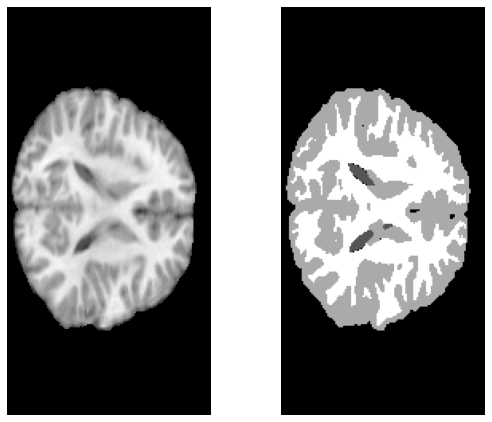

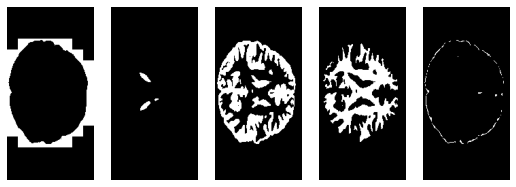

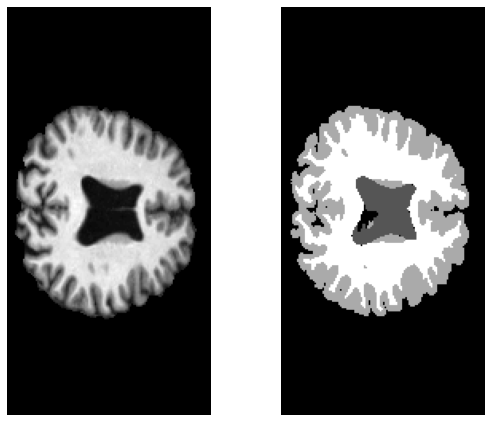

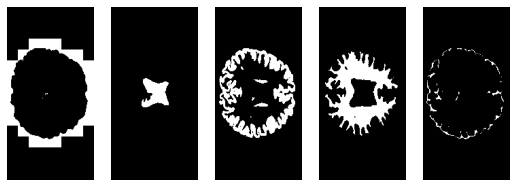

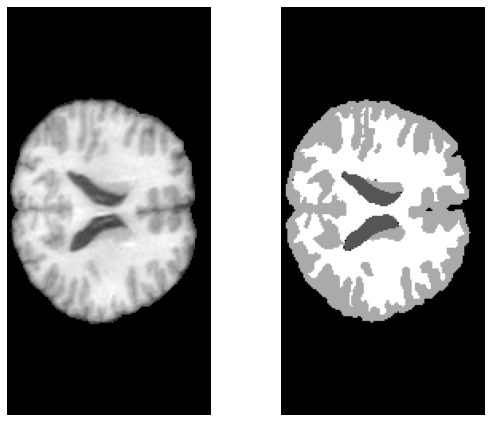

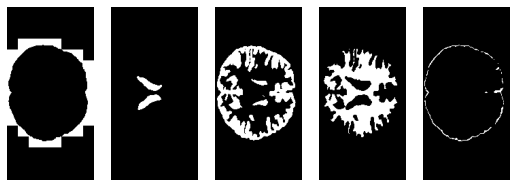

In [ ]:
slice_no =150
plot_stat = False

# obtain a list of test scans
test_scans = os.listdir(options['test_path'])
th = 0.5

# iterate through the scans and evaluate the results
metrics = np.zeros((len(test_scans), 9))

for i, scan_name in enumerate(test_scans):
    scan_path = os.path.join(options['test_path'], scan_name)
    print(scan_path)



    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                      input_data=options['input_data'],
                                      roi=options['roi'],
                                      patch_shape=options['patch_size'],
                                      step=options['sampling_step'],
                                      normalize=options['normalize'])
    lesion_out = np.zeros((infer_patches.shape[0],numLabels,infer_patches.shape[2],infer_patches.shape[3],infer_patches.shape[4])).astype('float32')
    batch_size = options['batch_size']

        # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()

    # reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs
    lesion_prob_BG = reconstruct_image(lesion_out[:,0], coordenates, scan.shape)
    lesion_prob_CSF = reconstruct_image(lesion_out[:,1], coordenates, scan.shape)
    lesion_prob_GM = reconstruct_image(lesion_out[:,2], coordenates, scan.shape)
    lesion_prob_WM = reconstruct_image(lesion_out[:,3], coordenates, scan.shape)
    if (numLabels == 5):
      lesion_prob_RN = reconstruct_image(lesion_out[:,4], coordenates, scan.shape)

    lesion_prob_BG = (lesion_prob_BG > th).astype('uint8')
    lesion_prob_CSF = (lesion_prob_CSF > th).astype('uint8')
    lesion_prob_GM = (lesion_prob_GM > th).astype('uint8')
    lesion_prob_WM = (lesion_prob_WM > th).astype('uint8')
    if (numLabels == 5):
      lesion_prob_RN = (lesion_prob_RN > th).astype('uint8')


    #scan_img = nib.load(os.path.join(scan_path, 'T1.nii.gz'))

    scan_img_load = nib.load(os.path.join(scan_path, 'T1.nii.gz'))
    
    scan_img = np.squeeze(scan_img_load.get_fdata().astype('float32'),axis=3)
    
    plt.figure(figsize=(9,7.5))
    plt.subplot(1,2,1)
    plt.imshow(scan_img[:,:,slice_no], cmap='gray')
    plt.axis('off')
    
    lesion_final = lesion_prob_CSF + lesion_prob_GM*2 + lesion_prob_WM*3;
    lesion_final[lesion_final>3] = 0
    
    plt.subplot(1,2,2)
    plt.imshow(lesion_final[:,:,slice_no], cmap='gray')
    plt.axis('off')

    save_img = nib.Nifti1Image(lesion_final, scan_img_load.affine, scan_img_load.header)
    nib.save(save_img, os.path.join(scan_path, scan_name+'_lesion_final_100.nii.gz'))

    if (numLabels == 4):
      plt.figure(figsize=(9,7.5))
      plt.subplot(1,4,1)
      plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,2)
      plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,3)
      plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
      plt.subplot(1,4,4)

      plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
    elif (numLabels == 5):
      plt.figure(figsize=(9,7.5))
      plt.subplot(1,5,1)
      plt.axis('off')      
      plt.imshow(lesion_prob_BG[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,2)
      plt.axis('off')
      plt.imshow(lesion_prob_CSF[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,3)
      plt.axis('off')
      plt.imshow(lesion_prob_GM[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,4)
      plt.axis('off')
      plt.imshow(lesion_prob_WM[:,:,slice_no], cmap='gray')
      plt.subplot(1,5,5)
      plt.axis('off')
      plt.imshow(lesion_prob_RN[:,:,slice_no], cmap='gray')